## 1. Setup and Imports

In [1]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score
)

# Grad-CAM for XAI
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 13.0


## 2. Dataset Architecture and Exploration

In [2]:
# Define dataset path
DATASET_PATH = './MLMI-2024'

# Define class names and body parts
CLASS_NAMES = ['Aedes aegypti', 'Culex quinquefasciatus']
BODY_PARTS = ['abdomen', 'full body', 'head', 'siphon']

# Explore dataset structure
def explore_dataset(dataset_path):
    """Explore and analyze the dataset structure"""
    print("=" * 70)
    print("DATASET ARCHITECTURE ANALYSIS")
    print("=" * 70)
    
    dataset_info = []
    total_images = 0
    
    for class_name in CLASS_NAMES:
        class_path = os.path.join(dataset_path, class_name)
        print(f"\n📁 Class: {class_name}")
        print("-" * 70)
        
        for body_part in BODY_PARTS:
            body_part_path = os.path.join(class_path, body_part)
            
            if os.path.exists(body_part_path):
                images = [f for f in os.listdir(body_part_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                num_images = len(images)
                total_images += num_images
                
                dataset_info.append({
                    'Class': class_name,
                    'Body Part': body_part,
                    'Number of Images': num_images
                })
                
                print(f"  • {body_part}: {num_images} images")
            else:
                print(f"  • {body_part}: Path not found!")
    
    print("\n" + "=" * 70)
    print(f"TOTAL IMAGES IN DATASET: {total_images}")
    print("=" * 70)
    
    # Create DataFrame
    df_info = pd.DataFrame(dataset_info)
    return df_info, total_images

# Run exploration
df_dataset_info, total_images = explore_dataset(DATASET_PATH)
print("\n\nDataset Summary Table:")
print(df_dataset_info.to_string(index=False))

DATASET ARCHITECTURE ANALYSIS

📁 Class: Aedes aegypti
----------------------------------------------------------------------
  • abdomen: 100 images
  • full body: 100 images
  • head: 100 images
  • siphon: 100 images

📁 Class: Culex quinquefasciatus
----------------------------------------------------------------------
  • abdomen: 100 images
  • full body: 100 images
  • head: 100 images
  • siphon: 100 images

TOTAL IMAGES IN DATASET: 800


Dataset Summary Table:
                 Class Body Part  Number of Images
         Aedes aegypti   abdomen               100
         Aedes aegypti full body               100
         Aedes aegypti      head               100
         Aedes aegypti    siphon               100
Culex quinquefasciatus   abdomen               100
Culex quinquefasciatus full body               100
Culex quinquefasciatus      head               100
Culex quinquefasciatus    siphon               100


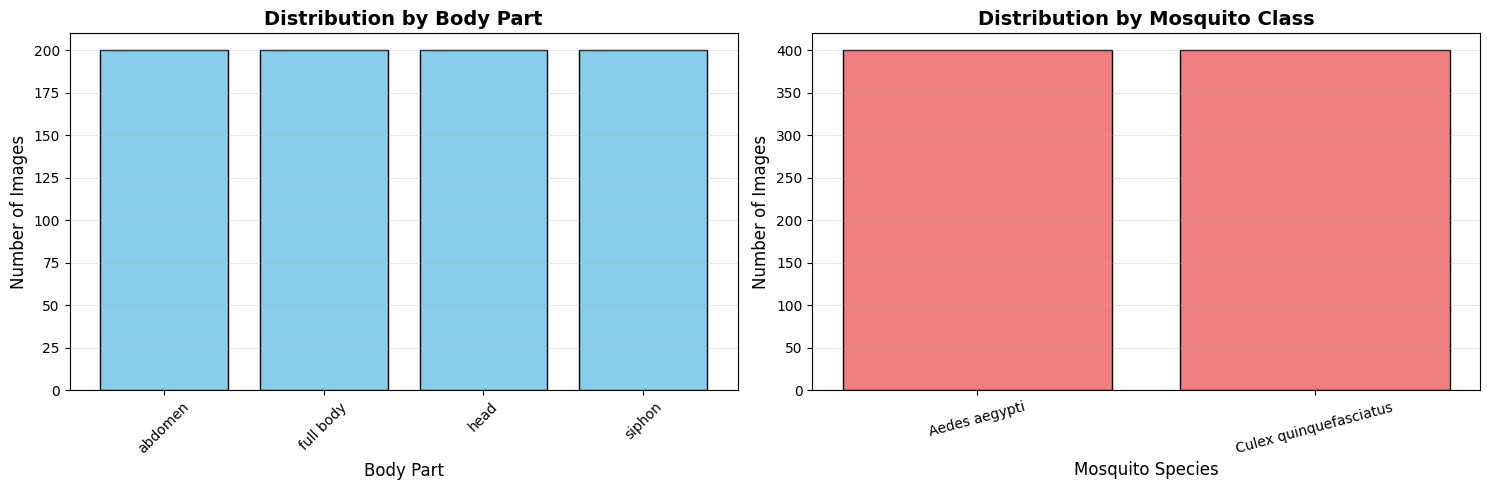

In [3]:
# Visualize dataset distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution by body part
body_part_counts = df_dataset_info.groupby('Body Part')['Number of Images'].sum()
axes[0].bar(body_part_counts.index, body_part_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution by Body Part', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Body Part', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Distribution by class
class_counts = df_dataset_info.groupby('Class')['Number of Images'].sum()
axes[1].bar(class_counts.index, class_counts.values, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution by Mosquito Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mosquito Species', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Data Collection and Categorization

In [4]:
# Collect all image paths and labels
def collect_image_paths(dataset_path):
    """Collect all image paths with their labels"""
    image_data = []
    
    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(dataset_path, class_name)
        
        for body_part in BODY_PARTS:
            body_part_path = os.path.join(class_path, body_part)
            
            if os.path.exists(body_part_path):
                images = [f for f in os.listdir(body_part_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                
                for img_name in images:
                    img_path = os.path.join(body_part_path, img_name)
                    image_data.append({
                        'image_path': img_path,
                        'class_name': class_name,
                        'class_idx': class_idx,
                        'body_part': body_part,
                        'image_name': img_name
                    })
    
    return pd.DataFrame(image_data)

# Collect dataset
df_images = collect_image_paths(DATASET_PATH)
print(f"Total images collected: {len(df_images)}")
print(f"\nDataset head:")
print(df_images.head(10))
print(f"\nClass distribution:")
print(df_images['class_name'].value_counts())

Total images collected: 800

Dataset head:
                                          image_path     class_name  \
0  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
1  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
2  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
3  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
4  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
5  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
6  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
7  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
8  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   
9  ./MLMI-2024\Aedes aegypti\abdomen\20231211_131...  Aedes aegypti   

   class_idx body_part           image_name  
0          0   abdomen  20231211_131111.jpg  
1          0   abdomen  20231211_131132.jpg  
2          0   abdomen  20231211_1312

## 4. Image Standardization - Resolution Analysis and Preprocessing

In [5]:
# Analyze image resolutions
def analyze_image_resolutions(df_images, sample_size=200):
    """Analyze image resolutions in the dataset"""
    print("Analyzing image resolutions (sampling for speed)...")
    
    # Sample images for analysis
    sample_df = df_images.sample(n=min(sample_size, len(df_images)), random_state=42)
    
    resolutions = []
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        try:
            img = Image.open(row['image_path'])
            resolutions.append({
                'width': img.width,
                'height': img.height,
                'aspect_ratio': img.width / img.height
            })
        except Exception as e:
            print(f"Error reading {row['image_path']}: {e}")
    
    df_resolutions = pd.DataFrame(resolutions)
    
    print("\n" + "=" * 70)
    print("RESOLUTION ANALYSIS")
    print("=" * 70)
    print(f"Width  - Min: {df_resolutions['width'].min()}, Max: {df_resolutions['width'].max()}, Mean: {df_resolutions['width'].mean():.2f}")
    print(f"Height - Min: {df_resolutions['height'].min()}, Max: {df_resolutions['height'].max()}, Mean: {df_resolutions['height'].mean():.2f}")
    print(f"Aspect Ratio - Min: {df_resolutions['aspect_ratio'].min():.2f}, Max: {df_resolutions['aspect_ratio'].max():.2f}")
    print("=" * 70)
    
    return df_resolutions

df_resolutions = analyze_image_resolutions(df_images)

Analyzing image resolutions (sampling for speed)...


100%|██████████| 200/200 [00:00<00:00, 3225.78it/s]


RESOLUTION ANALYSIS
Width  - Min: 3456, Max: 3456, Mean: 3456.00
Height - Min: 3456, Max: 3456, Mean: 3456.00
Aspect Ratio - Min: 1.00, Max: 1.00


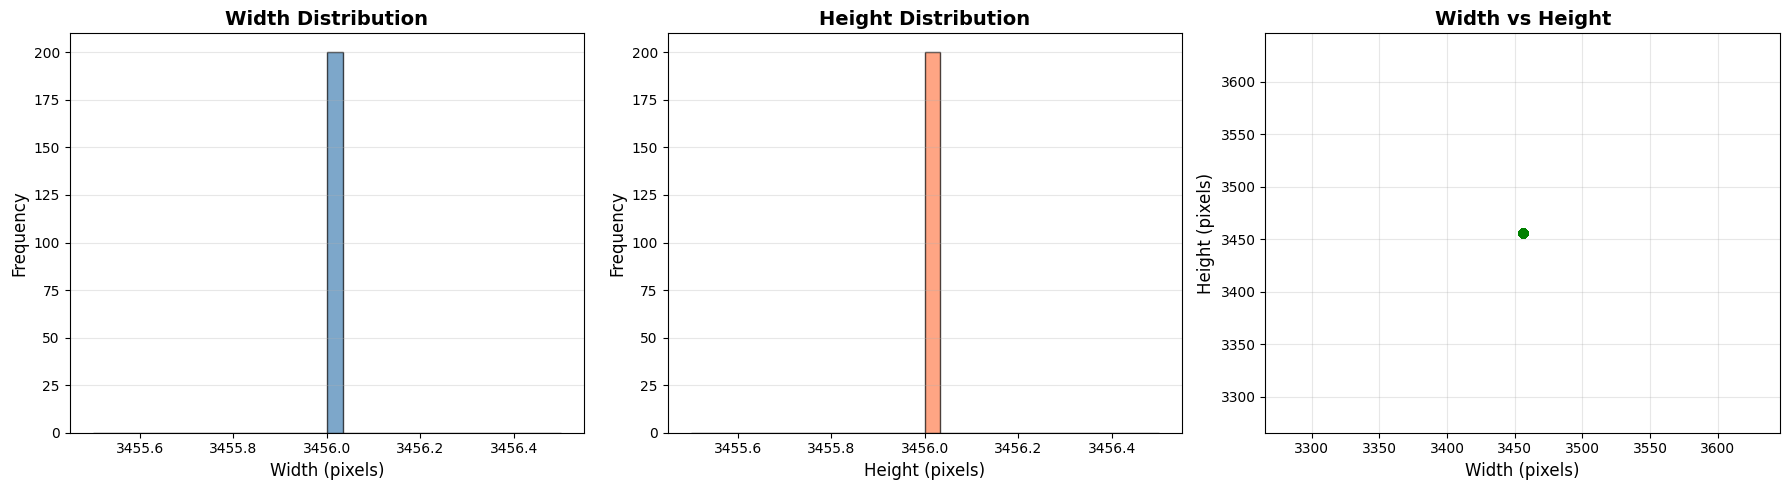


✓ Standardizing all images to 224x224 pixels for DenseNet-121


In [6]:
# Visualize resolution distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_resolutions['width'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Width Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Width (pixels)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(df_resolutions['height'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Height Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Height (pixels)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

axes[2].scatter(df_resolutions['width'], df_resolutions['height'], alpha=0.5, color='green')
axes[2].set_title('Width vs Height', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Width (pixels)', fontsize=12)
axes[2].set_ylabel('Height (pixels)', fontsize=12)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Decision on standardization
STANDARD_SIZE = 224  # DenseNet-121 standard input size
print(f"\n✓ Standardizing all images to {STANDARD_SIZE}x{STANDARD_SIZE} pixels for DenseNet-121")

## 5. Dataset Splitting (70% Train, 15% Val, 15% Test)

In [7]:
# Stratified split to maintain class balance
def split_dataset(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split dataset into train, validation, and test sets with stratification
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    # First split: train vs (val + test)
    train_df, temp_df = train_test_split(
        df,
        train_size=train_ratio,
        stratify=df['class_idx'],
        random_state=random_state
    )
    
    # Second split: val vs test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_ratio_adjusted,
        stratify=temp_df['class_idx'],
        random_state=random_state
    )
    
    return train_df, val_df, test_df

# Perform split
train_df, val_df, test_df = split_dataset(df_images)

print("=" * 70)
print("DATASET SPLITTING RESULTS")
print("=" * 70)
print(f"Total images: {len(df_images)}")
print(f"\nTrain set: {len(train_df)} images ({len(train_df)/len(df_images)*100:.1f}%)")
print(f"Val set:   {len(val_df)} images ({len(val_df)/len(df_images)*100:.1f}%)")
print(f"Test set:  {len(test_df)} images ({len(test_df)/len(df_images)*100:.1f}%)")

print("\n" + "-" * 70)
print("Class distribution in each set:")
print("-" * 70)
print("\nTrain set:")
print(train_df['class_name'].value_counts())
print("\nValidation set:")
print(val_df['class_name'].value_counts())
print("\nTest set:")
print(test_df['class_name'].value_counts())
print("=" * 70)

DATASET SPLITTING RESULTS
Total images: 800

Train set: 560 images (70.0%)
Val set:   120 images (15.0%)
Test set:  120 images (15.0%)

----------------------------------------------------------------------
Class distribution in each set:
----------------------------------------------------------------------

Train set:
class_name
Culex quinquefasciatus    280
Aedes aegypti             280
Name: count, dtype: int64

Validation set:
class_name
Culex quinquefasciatus    60
Aedes aegypti             60
Name: count, dtype: int64

Test set:
class_name
Culex quinquefasciatus    60
Aedes aegypti             60
Name: count, dtype: int64


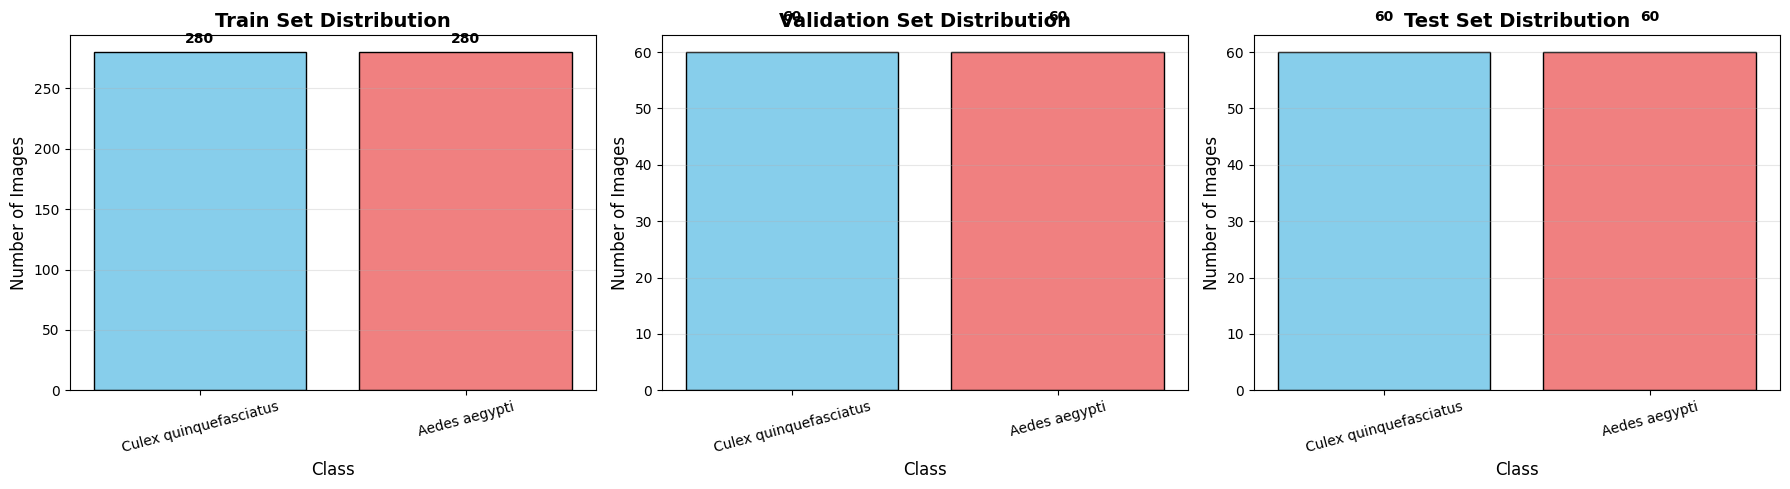

In [8]:
# Visualize split distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_split, title) in enumerate([(train_df, 'Train'), (val_df, 'Validation'), (test_df, 'Test')]):
    class_counts = df_split['class_name'].value_counts()
    axes[idx].bar(class_counts.index, class_counts.values, color=['skyblue', 'lightcoral'], edgecolor='black')
    axes[idx].set_title(f'{title} Set Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Class', fontsize=12)
    axes[idx].set_ylabel('Number of Images', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=15)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(class_counts.values):
        axes[idx].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Custom Dataset Class with Augmentation

In [9]:
# Custom Dataset class
class MosquitoDataset(Dataset):
    """
    Custom PyTorch Dataset for mosquito larvae images
    """
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['class_idx']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ Custom Dataset class defined")

✓ Custom Dataset class defined


## 7. Data Augmentation and Transforms

In [10]:
# Define custom augmentation strategy
# Base transformations (always applied): rotation, translation, shearing, horizontal flip
# Then randomly apply 2 additional augmentations

import torchvision.transforms as T

# Define base transformations (always applied)
base_transforms_list = [
    T.Resize((STANDARD_SIZE, STANDARD_SIZE)),
    T.RandomAffine(
        degrees=10,           # Rotation ±10 degrees
        translate=(0.1, 0.1), # Translation up to 10%
        shear=10              # Shearing ±10 degrees
    ),
    T.RandomHorizontalFlip(p=0.5),  # Horizontal flip
]

# Define pool of additional augmentations (2 will be randomly selected per image)
additional_augmentations_pool = [
    T.RandomVerticalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    T.RandomAutocontrast(p=0.5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.RandomRotation(degrees=20),
]

class CustomAugmentation:
    """
    Custom augmentation that applies base transforms + 2 random augmentations
    """
    def __init__(self, base_transforms, aug_pool, num_random=2):
        self.base_transforms = T.Compose(base_transforms)
        self.aug_pool = aug_pool
        self.num_random = num_random
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    def __call__(self, img):
        import random as rand
        # Apply base transformations
        img = self.base_transforms(img)
        
        # Randomly select and apply 2 augmentations from pool
        selected_augs = rand.sample(self.aug_pool, self.num_random)
        for aug in selected_augs:
            img = aug(img)
        
        # Convert to tensor and normalize
        img = self.to_tensor(img)
        img = self.normalize(img)
        
        return img

# Training transforms with custom augmentation
train_transforms = CustomAugmentation(base_transforms_list, additional_augmentations_pool, num_random=2)

# Validation and test transforms (no augmentation)
val_test_transforms = T.Compose([
    T.Resize((STANDARD_SIZE, STANDARD_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("=" * 70)
print("CUSTOM AUGMENTATION STRATEGY")
print("=" * 70)
print("Base transformations (always applied to training images):")
print("  • Rotation: ±10 degrees")
print("  • Translation: up to 10% in x and y")
print("  • Shearing: ±10 degrees")
print("  • Horizontal flip: 50% probability")
print("\nAdditional augmentations (randomly select 2 per image):")
print("  1. Random vertical flip")
print("  2. Color jitter (brightness, contrast, saturation, hue)")
print("  3. Random sharpness adjustment")
print("  4. Random autocontrast")
print("  5. Gaussian blur")
print("  6. Additional rotation (±20 degrees)")
print("\nEach training image gets: Base transforms + 2 random augmentations")
print("\nValidation/Test: Only resize and normalize (no augmentation)")
print("=" * 70)

CUSTOM AUGMENTATION STRATEGY
Base transformations (always applied to training images):
  • Rotation: ±10 degrees
  • Translation: up to 10% in x and y
  • Shearing: ±10 degrees
  • Horizontal flip: 50% probability

Additional augmentations (randomly select 2 per image):
  1. Random vertical flip
  2. Color jitter (brightness, contrast, saturation, hue)
  3. Random sharpness adjustment
  4. Random autocontrast
  5. Gaussian blur
  6. Additional rotation (±20 degrees)

Each training image gets: Base transforms + 2 random augmentations

Validation/Test: Only resize and normalize (no augmentation)


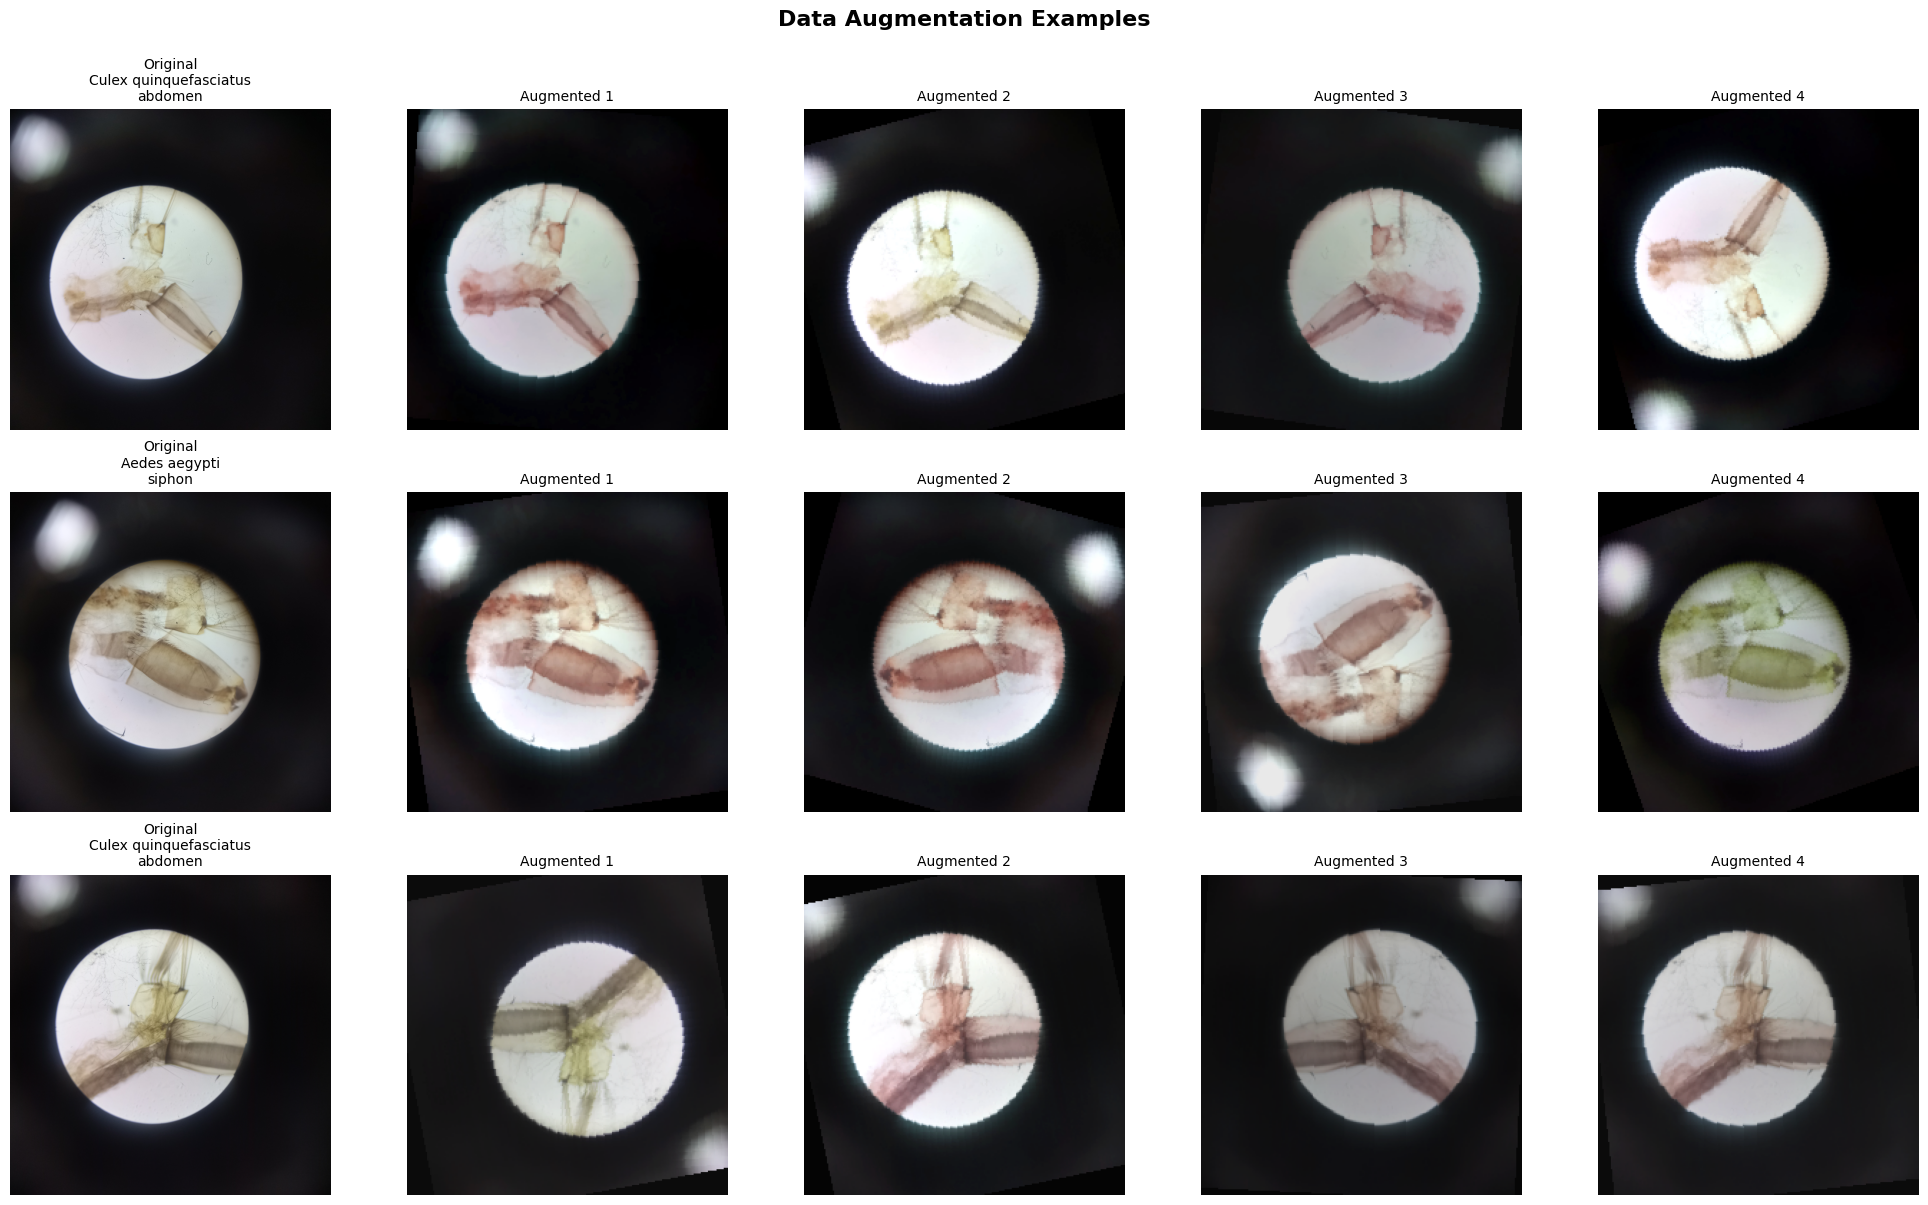

In [11]:
# Visualize augmentation examples
def visualize_augmentation(df, num_samples=3):
    """Visualize original and augmented images"""
    sample_df = df.sample(n=num_samples, random_state=42)
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        img_path = row['image_path']
        img = Image.open(img_path).convert('RGB')
        
        # Original
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"Original\n{row['class_name']}\n{row['body_part']}", fontsize=10)
        axes[idx, 0].axis('off')
        
        # Apply augmentations 4 times
        for aug_idx in range(1, 5):
            # Use a transform that outputs PIL for visualization
            aug_transform = transforms.Compose([
                transforms.Resize((STANDARD_SIZE, STANDARD_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.RandomRotation(degrees=20),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            ])
            aug_img = aug_transform(img)
            axes[idx, aug_idx].imshow(aug_img)
            axes[idx, aug_idx].set_title(f"Augmented {aug_idx}", fontsize=10)
            axes[idx, aug_idx].axis('off')
    
    plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_df, num_samples=3)

## 8. Create Data Loaders

In [12]:
# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 0  # Adjust based on your system

# Create datasets
train_dataset = MosquitoDataset(train_df, transform=train_transforms)
val_dataset = MosquitoDataset(val_df, transform=val_test_transforms)
test_dataset = MosquitoDataset(test_df, transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print("=" * 70)
print("DATA LOADERS CREATED")
print("=" * 70)
print(f"Batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print("=" * 70)

DATA LOADERS CREATED
Batch size: 32
Train batches: 18
Validation batches: 4
Test batches: 4


## 9. Model Selection - DenseNet-121

In [13]:
# Load pre-trained DenseNet-121 and modify for binary classification
def create_densenet121(num_classes=2, pretrained=True):
    """
    Create DenseNet-121 model with custom final layer
    """
    model = models.densenet121(pretrained=pretrained)
    
    # Modify the final classifier layer
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    
    return model

# Create model
model = create_densenet121(num_classes=2, pretrained=True)
model = model.to(device)

print("=" * 70)
print("MODEL: DenseNet-121")
print("=" * 70)
print(f"Pre-trained on ImageNet: Yes")
print(f"Number of classes: 2 (Binary Classification)")
print(f"Model loaded on: {device}")
print("=" * 70)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\tamji/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:02<00:00, 11.7MB/s]


MODEL: DenseNet-121
Pre-trained on ImageNet: Yes
Number of classes: 2 (Binary Classification)
Model loaded on: cuda

Total parameters: 6,955,906
Trainable parameters: 6,955,906


## 10. Training Setup - Loss, Optimizer, Scheduler

In [18]:
# Training hyperparameters
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler (verbose removed for PyTorch 2.x compatibility)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Optimizer: Adam")
print(f"Loss function: CrossEntropyLoss")
print(f"LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print("=" * 70)

TRAINING CONFIGURATION
Number of epochs: 25
Learning rate: 0.001
Weight decay: 0.0001
Optimizer: Adam
Loss function: CrossEntropyLoss
LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## 11. Training Loop with Validation

In [15]:
# Training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100 * correct / total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """
    Validate for one epoch
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100 * correct / total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

print("✓ Training functions defined")

✓ Training functions defined


In [16]:
# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

best_val_acc = 0.0
best_model_wts = None

print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)
print(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict().copy()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'best_densenet121_model.pth')
        print("✓ Best model saved!")

print("\n" + "=" * 70)
print("TRAINING COMPLETED")
print("=" * 70)
print(f"Training ended at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print("=" * 70)

# Load best model weights
model.load_state_dict(best_model_wts)
print("\n✓ Best model weights loaded")

STARTING TRAINING
Training started at: 2026-01-19 20:39:26

Epoch [1/50]
----------------------------------------------------------------------


Train Loss: 0.4023 | Train Acc: 80.36%
Val Loss:   8.6803 | Val Acc:   50.00%
Learning Rate: 0.001000
✓ Best model saved!

Epoch [2/50]
----------------------------------------------------------------------


Train Loss: 0.1681 | Train Acc: 93.75%
Val Loss:   0.5386 | Val Acc:   83.33%
Learning Rate: 0.001000
✓ Best model saved!

Epoch [3/50]
----------------------------------------------------------------------


Train Loss: 0.1494 | Train Acc: 94.46%
Val Loss:   0.2494 | Val Acc:   90.00%
Learning Rate: 0.001000
✓ Best model saved!

Epoch [4/50]
----------------------------------------------------------------------


Train Loss: 0.0653 | Train Acc: 98.04%
Val Loss:   0.0624 | Val Acc:   98.33%
Learning Rate: 0.001000
✓ Best model saved!

Epoch [5/50]
----------------------------------------------------------------------


Train Loss: 0.0536 | Train Acc: 98.21%
Val Loss:   0.0378 | Val Acc:   98.33%
Learning Rate: 0.001000

Epoch [6/50]
----------------------------------------------------------------------


Train Loss: 0.0771 | Train Acc: 96.79%
Val Loss:   0.1697 | Val Acc:   94.17%
Learning Rate: 0.001000

Epoch [7/50]
----------------------------------------------------------------------


Train Loss: 0.1048 | Train Acc: 95.71%
Val Loss:   0.9942 | Val Acc:   68.33%
Learning Rate: 0.001000

Epoch [8/50]
----------------------------------------------------------------------


Train Loss: 0.0790 | Train Acc: 97.50%
Val Loss:   0.0547 | Val Acc:   96.67%
Learning Rate: 0.001000

Epoch [9/50]
----------------------------------------------------------------------


Train Loss: 0.0520 | Train Acc: 97.86%
Val Loss:   0.7638 | Val Acc:   75.00%
Learning Rate: 0.001000

Epoch [10/50]
----------------------------------------------------------------------


Train Loss: 0.0502 | Train Acc: 98.39%
Val Loss:   0.2367 | Val Acc:   92.50%
Learning Rate: 0.001000

Epoch [11/50]
----------------------------------------------------------------------


Train Loss: 0.0643 | Train Acc: 97.68%
Val Loss:   0.0772 | Val Acc:   96.67%
Learning Rate: 0.000500

Epoch [12/50]
----------------------------------------------------------------------


Train Loss: 0.0891 | Train Acc: 97.50%
Val Loss:   0.0381 | Val Acc:   99.17%
Learning Rate: 0.000500
✓ Best model saved!

Epoch [13/50]
----------------------------------------------------------------------


Train Loss: 0.0266 | Train Acc: 99.46%
Val Loss:   0.0213 | Val Acc:   99.17%
Learning Rate: 0.000500

Epoch [14/50]
----------------------------------------------------------------------


Train Loss: 0.0307 | Train Acc: 99.29%
Val Loss:   0.1258 | Val Acc:   96.67%
Learning Rate: 0.000500

Epoch [15/50]
----------------------------------------------------------------------


Train Loss: 0.0128 | Train Acc: 99.29%
Val Loss:   0.0363 | Val Acc:   98.33%
Learning Rate: 0.000500

Epoch [16/50]
----------------------------------------------------------------------


Train Loss: 0.0104 | Train Acc: 99.82%
Val Loss:   0.0039 | Val Acc:   100.00%
Learning Rate: 0.000500
✓ Best model saved!

Epoch [17/50]
----------------------------------------------------------------------


Train Loss: 0.0256 | Train Acc: 99.29%
Val Loss:   0.0544 | Val Acc:   96.67%
Learning Rate: 0.000500

Epoch [18/50]
----------------------------------------------------------------------


Train Loss: 0.0288 | Train Acc: 98.75%
Val Loss:   0.0343 | Val Acc:   99.17%
Learning Rate: 0.000500

Epoch [19/50]
----------------------------------------------------------------------


Train Loss: 0.0149 | Train Acc: 99.82%
Val Loss:   0.2242 | Val Acc:   92.50%
Learning Rate: 0.000500

Epoch [20/50]
----------------------------------------------------------------------


Train Loss: 0.0404 | Train Acc: 98.75%
Val Loss:   0.0268 | Val Acc:   99.17%
Learning Rate: 0.000500

Epoch [21/50]
----------------------------------------------------------------------


Train Loss: 0.0271 | Train Acc: 98.93%
Val Loss:   0.0321 | Val Acc:   99.17%
Learning Rate: 0.000500

Epoch [22/50]
----------------------------------------------------------------------


Train Loss: 0.0111 | Train Acc: 99.64%
Val Loss:   0.0259 | Val Acc:   98.33%
Learning Rate: 0.000250

Epoch [23/50]
----------------------------------------------------------------------


Train Loss: 0.0061 | Train Acc: 99.82%
Val Loss:   0.0076 | Val Acc:   100.00%
Learning Rate: 0.000250

Epoch [24/50]
----------------------------------------------------------------------


Train Loss: 0.0074 | Train Acc: 99.64%
Val Loss:   0.0258 | Val Acc:   99.17%
Learning Rate: 0.000250

Epoch [25/50]
----------------------------------------------------------------------


Train Loss: 0.0160 | Train Acc: 99.46%
Val Loss:   0.0099 | Val Acc:   99.17%
Learning Rate: 0.000250

Epoch [26/50]
----------------------------------------------------------------------


KeyboardInterrupt: 

## 12. Training History Visualization

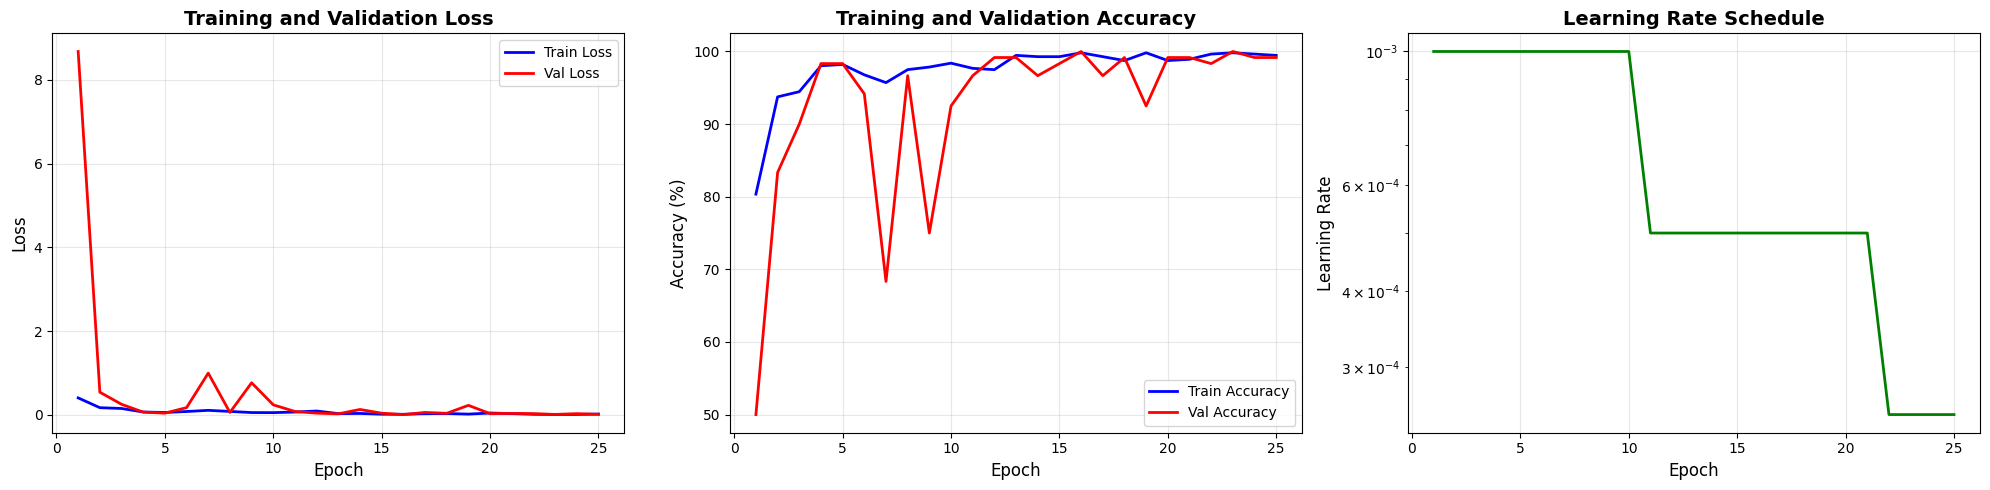

✓ Training history plot saved as 'training_history_densenet121.png'


In [19]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

epochs_range = range(1, NUM_EPOCHS + 1)

# Loss plot
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, [acc*100 for acc in history['train_acc']], 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs_range, [acc*100 for acc in history['val_acc']], 'r-', label='Val Accuracy', linewidth=2)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

# Learning rate plot
axes[2].plot(epochs_range, history['learning_rates'], 'g-', linewidth=2)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_yscale('log')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_densenet121.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved as 'training_history_densenet121.png'")

## 13. Model Evaluation on Test Set

In [20]:
# Comprehensive evaluation function
def evaluate_model(model, dataloader, device):
    """
    Evaluate model and return predictions, labels, and probabilities
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Evaluate on test set
print("=" * 70)
print("EVALUATING ON TEST SET")
print("=" * 70)

test_preds, test_labels, test_probs = evaluate_model(model, test_loader, device)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='binary')
test_recall = recall_score(test_labels, test_preds, average='binary')
test_f1 = f1_score(test_labels, test_preds, average='binary')

print("\nTest Set Performance:")
print("-" * 70)
print(f"Accuracy:  {test_accuracy*100:.2f}%")
print(f"Precision: {test_precision*100:.2f}%")
print(f"Recall:    {test_recall*100:.2f}%")
print(f"F1-Score:  {test_f1*100:.2f}%")
print("=" * 70)

EVALUATING ON TEST SET


Evaluating: 100%|██████████| 4/4 [00:17<00:00,  4.45s/it]


Test Set Performance:
----------------------------------------------------------------------
Accuracy:  100.00%
Precision: 100.00%
Recall:    100.00%
F1-Score:  100.00%


In [21]:
# Detailed classification report
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES, digits=4))
print("=" * 70)


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

         Aedes aegypti     1.0000    1.0000    1.0000        60
Culex quinquefasciatus     1.0000    1.0000    1.0000        60

              accuracy                         1.0000       120
             macro avg     1.0000    1.0000    1.0000       120
          weighted avg     1.0000    1.0000    1.0000       120



## 14. Confusion Matrix

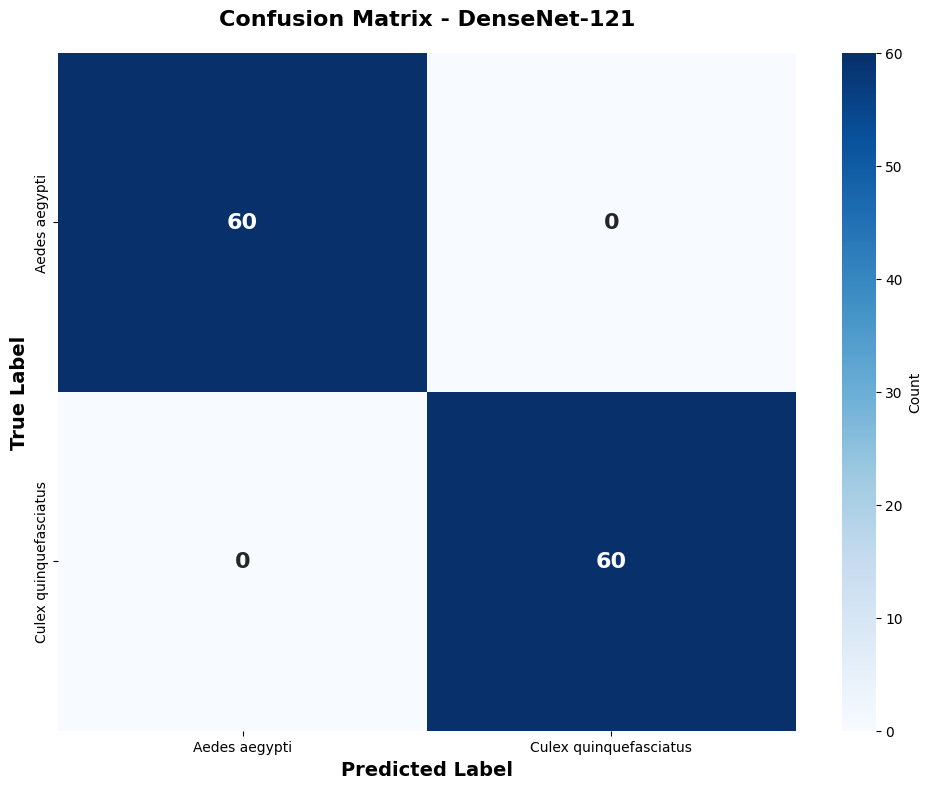

✓ Confusion matrix saved as 'confusion_matrix_densenet121.png'


In [22]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - DenseNet-121', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_densenet121.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix_densenet121.png'")

## 15. ROC Curve and AUC

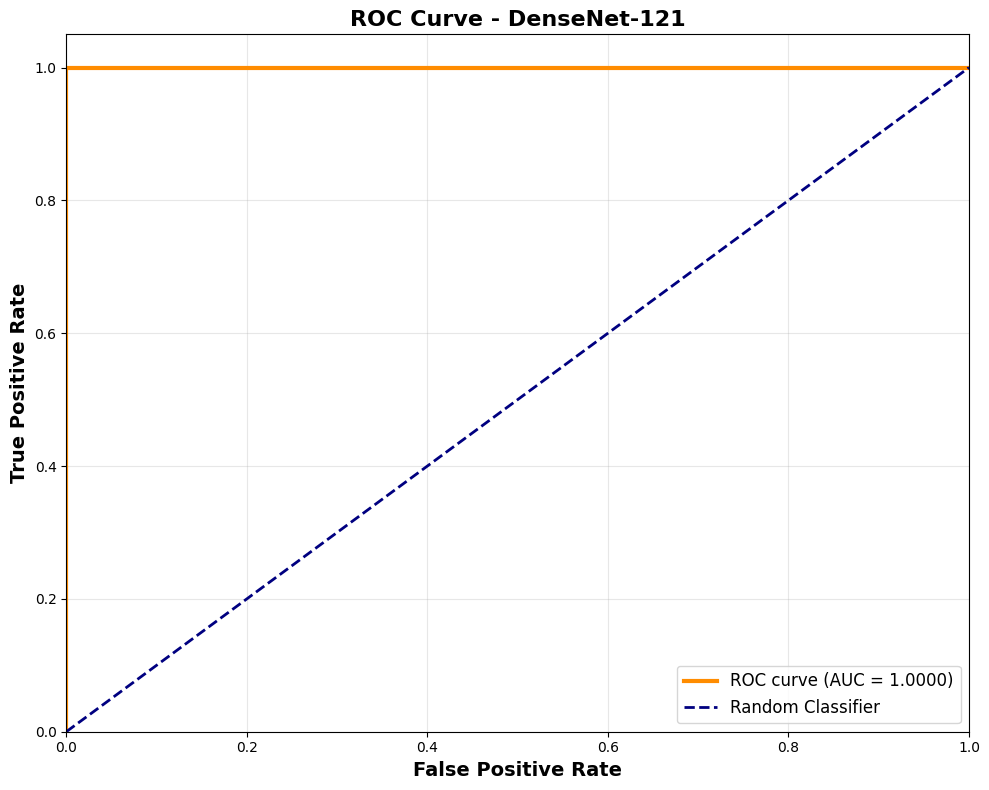

✓ ROC-AUC Score: 1.0000
✓ ROC curve saved as 'roc_curve_densenet121.png'


In [23]:
# ROC Curve for binary classification
# Use probabilities of positive class (class 1)
fpr, tpr, thresholds = roc_curve(test_labels, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curve - DenseNet-121', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve_densenet121.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC-AUC Score: {roc_auc:.4f}")
print("✓ ROC curve saved as 'roc_curve_densenet121.png'")

## 16. Per-Class Metrics Analysis


PER-CLASS METRICS
                 Class  Precision  Recall  F1-Score
         Aedes aegypti        1.0     1.0       1.0
Culex quinquefasciatus        1.0     1.0       1.0


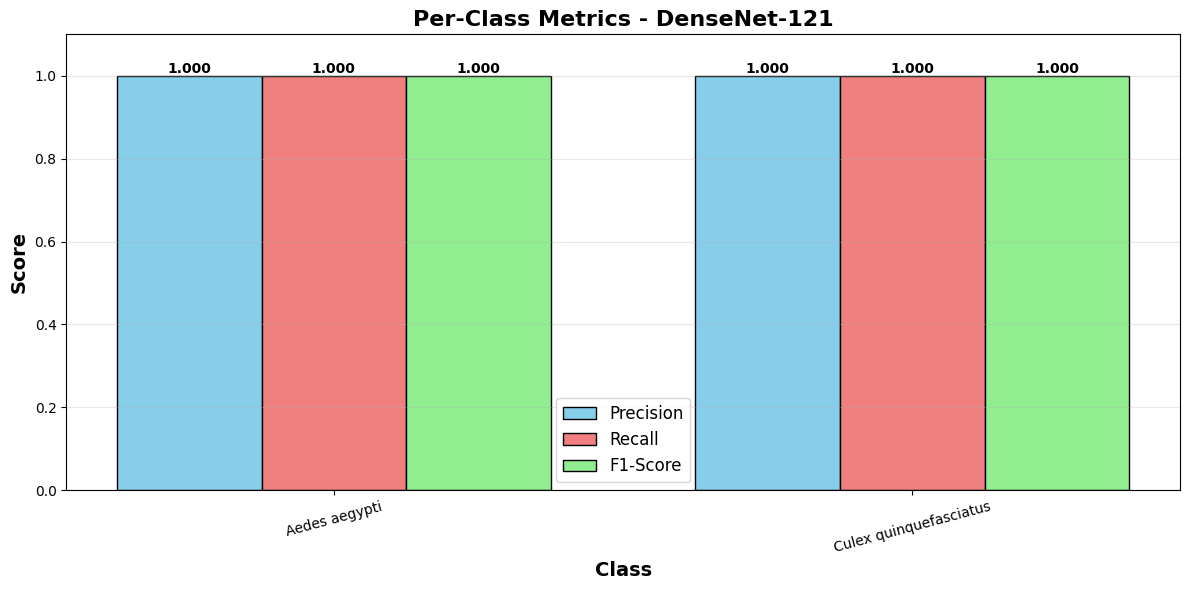


✓ Per-class metrics plot saved as 'per_class_metrics_densenet121.png'


In [24]:
# Per-class metrics
precision_per_class = precision_score(test_labels, test_preds, average=None)
recall_per_class = recall_score(test_labels, test_preds, average=None)
f1_per_class = f1_score(test_labels, test_preds, average=None)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

print("\n" + "=" * 70)
print("PER-CLASS METRICS")
print("=" * 70)
print(metrics_df.to_string(index=False))
print("=" * 70)

# Visualize per-class metrics
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CLASS_NAMES))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', color='skyblue', edgecolor='black')
bars2 = ax.bar(x, recall_per_class, width, label='Recall', color='lightcoral', edgecolor='black')
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='lightgreen', edgecolor='black')

ax.set_xlabel('Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Per-Class Metrics - DenseNet-121', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=15)
ax.legend(fontsize=12)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.savefig('per_class_metrics_densenet121.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Per-class metrics plot saved as 'per_class_metrics_densenet121.png'")

## 17. Explainable AI (XAI) - Grad-CAM Implementation

In [25]:
# Grad-CAM implementation
def apply_gradcam(model, img_tensor, target_layer, target_class=None):
    """
    Apply Grad-CAM to visualize what the model is looking at
    """
    # Create Grad-CAM object (use_cuda removed for newer pytorch_grad_cam versions)
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    # Generate CAM
    targets = [ClassifierOutputTarget(target_class)] if target_class is not None else None
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return grayscale_cam

def denormalize_image(img_tensor):
    """
    Denormalize image tensor for visualization
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_denorm = img_tensor * std + mean
    img_denorm = torch.clamp(img_denorm, 0, 1)
    return img_denorm

print("✓ Grad-CAM functions defined")

✓ Grad-CAM functions defined


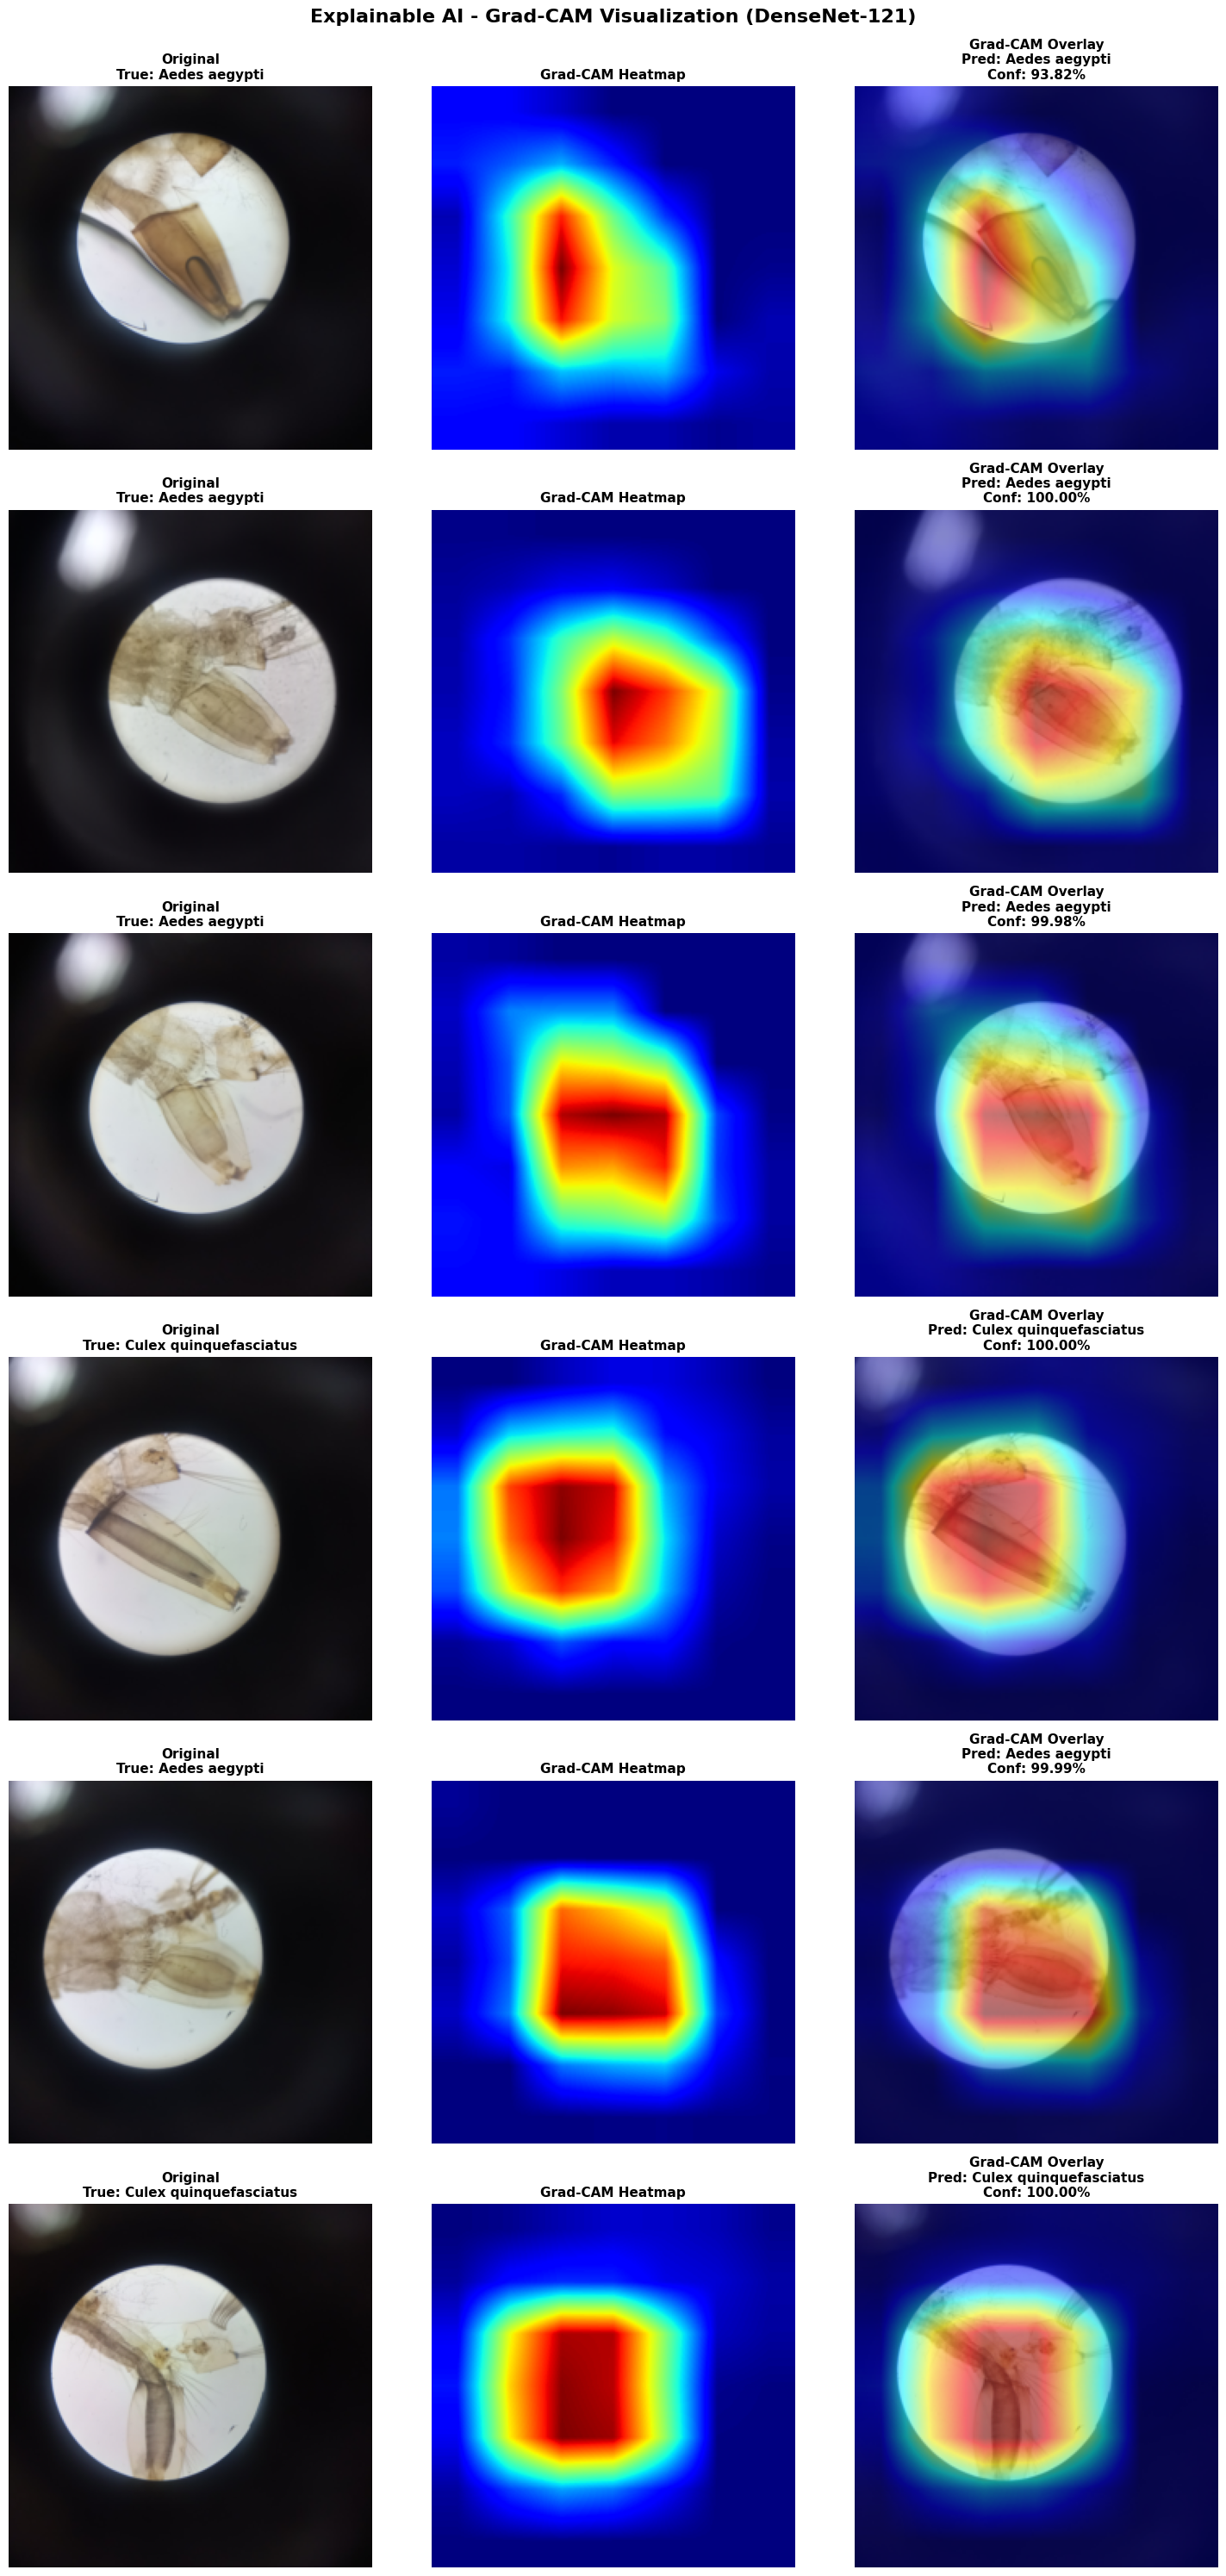


✓ Grad-CAM visualizations saved as 'gradcam_visualization_densenet121.png'


In [26]:
# Visualize Grad-CAM for sample images
def visualize_gradcam_samples(model, dataset, num_samples=6, target_layer=None):
    """
    Visualize Grad-CAM for random samples
    """
    if target_layer is None:
        # Use the last convolutional layer of DenseNet-121
        target_layer = model.features[-1]
    
    model.eval()
    
    # Get random samples
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for idx, sample_idx in enumerate(indices):
        img_tensor, true_label = dataset[sample_idx]
        
        # Get prediction
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0).to(device))
            pred_prob = torch.softmax(output, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1).item()
            confidence = pred_prob[0, pred_label].item()
        
        # Denormalize image
        img_denorm = denormalize_image(img_tensor)
        img_np = img_denorm.permute(1, 2, 0).cpu().numpy()
        
        # Apply Grad-CAM
        grayscale_cam = apply_gradcam(model, img_tensor.to(device), target_layer, pred_label)
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
        
        # Plot original image
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f'Original\nTrue: {CLASS_NAMES[true_label]}', fontsize=11, fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Plot Grad-CAM heatmap
        axes[idx, 1].imshow(grayscale_cam, cmap='jet')
        axes[idx, 1].set_title('Grad-CAM Heatmap', fontsize=11, fontweight='bold')
        axes[idx, 1].axis('off')
        
        # Plot overlayed image
        axes[idx, 2].imshow(cam_image)
        axes[idx, 2].set_title(f'Grad-CAM Overlay\nPred: {CLASS_NAMES[pred_label]}\nConf: {confidence:.2%}', 
                              fontsize=11, fontweight='bold')
        axes[idx, 2].axis('off')
    
    plt.suptitle('Explainable AI - Grad-CAM Visualization (DenseNet-121)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('gradcam_visualization_densenet121.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate Grad-CAM visualizations
visualize_gradcam_samples(model, test_dataset, num_samples=6)
print("\n✓ Grad-CAM visualizations saved as 'gradcam_visualization_densenet121.png'")

## 18. Biological Feature Analysis with Grad-CAM

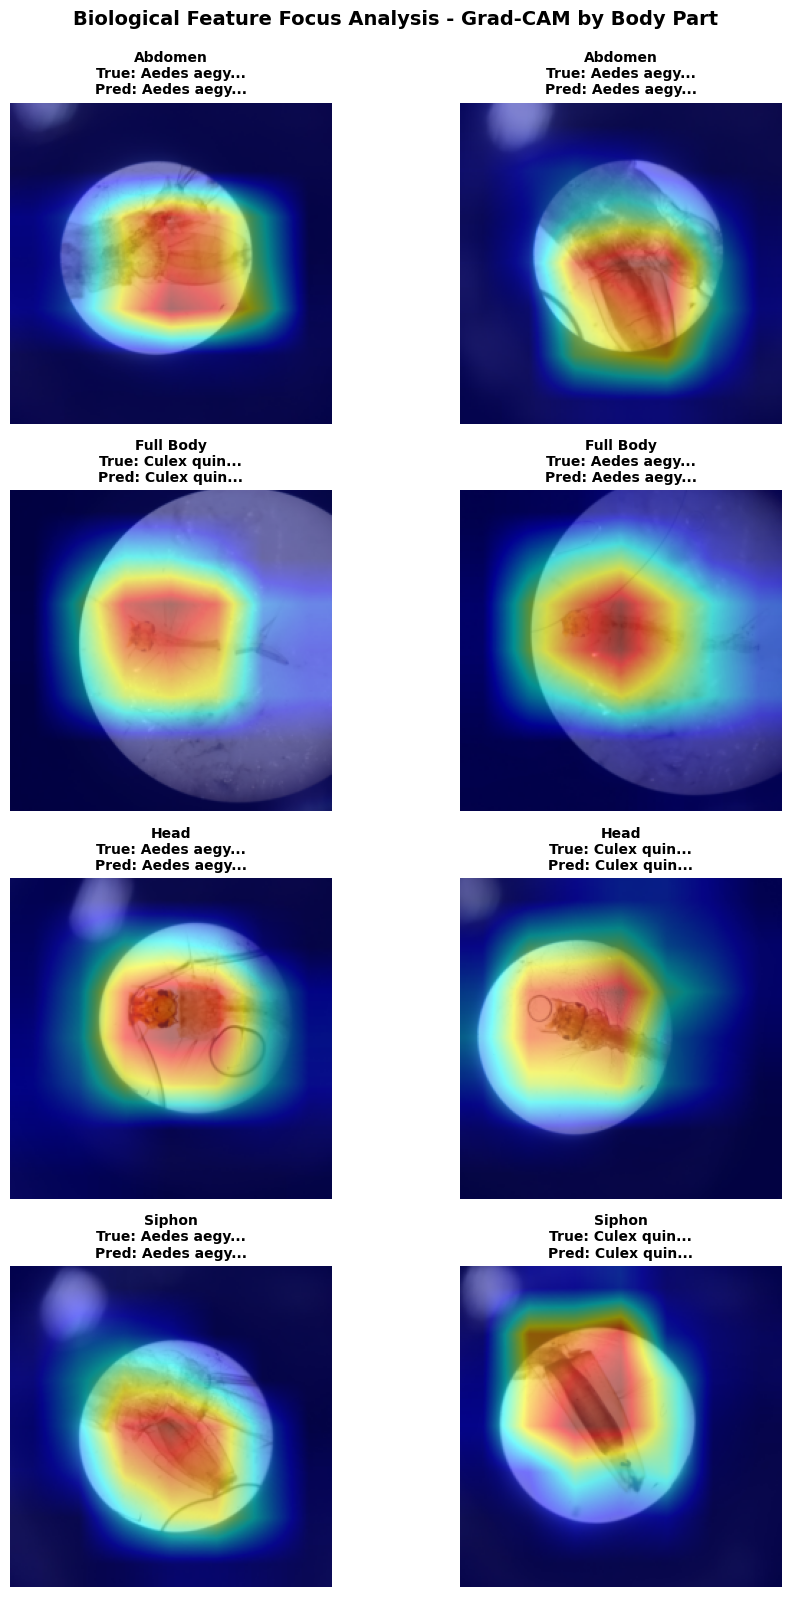


✓ Biological focus analysis saved as 'biological_focus_analysis_densenet121.png'


In [27]:
# Analyze which biological features the model focuses on
def analyze_biological_focus(model, dataset, body_parts, num_per_part=2):
    """
    Analyze model focus on different body parts
    """
    target_layer = model.features[-1]
    model.eval()
    
    # Get dataset dataframe
    dataset_df = test_df.reset_index(drop=True)
    
    fig, axes = plt.subplots(len(BODY_PARTS), num_per_part, figsize=(10, 4*len(BODY_PARTS)))
    
    for part_idx, body_part in enumerate(BODY_PARTS):
        # Filter by body part
        part_indices = dataset_df[dataset_df['body_part'] == body_part].index.tolist()
        
        if len(part_indices) < num_per_part:
            continue
        
        selected_indices = random.sample(part_indices, num_per_part)
        
        for sample_idx, dataset_idx in enumerate(selected_indices):
            img_tensor, true_label = dataset[dataset_idx]
            
            # Get prediction
            with torch.no_grad():
                output = model(img_tensor.unsqueeze(0).to(device))
                pred_label = torch.argmax(output, dim=1).item()
            
            # Denormalize and prepare image
            img_denorm = denormalize_image(img_tensor)
            img_np = img_denorm.permute(1, 2, 0).cpu().numpy()
            
            # Apply Grad-CAM
            grayscale_cam = apply_gradcam(model, img_tensor.to(device), target_layer, pred_label)
            cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
            
            # Plot
            ax = axes[part_idx, sample_idx] if num_per_part > 1 else axes[part_idx]
            ax.imshow(cam_image)
            ax.set_title(f'{body_part.title()}\nTrue: {CLASS_NAMES[true_label][:10]}...\nPred: {CLASS_NAMES[pred_label][:10]}...', 
                        fontsize=10, fontweight='bold')
            ax.axis('off')
    
    plt.suptitle('Biological Feature Focus Analysis - Grad-CAM by Body Part', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('biological_focus_analysis_densenet121.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run biological feature analysis
analyze_biological_focus(model, test_dataset, BODY_PARTS, num_per_part=2)
print("\n✓ Biological focus analysis saved as 'biological_focus_analysis_densenet121.png'")

## 19. Comprehensive Results Summary

In [28]:
# Create comprehensive results summary
results_summary = {
    'Model': 'DenseNet-121',
    'Dataset': 'MLMI-2024',
    'Total Images': len(df_images),
    'Train Images': len(train_df),
    'Val Images': len(val_df),
    'Test Images': len(test_df),
    'Number of Classes': 2,
    'Classes': ', '.join(CLASS_NAMES),
    'Input Size': f'{STANDARD_SIZE}x{STANDARD_SIZE}',
    'Batch Size': BATCH_SIZE,
    'Epochs': NUM_EPOCHS,
    'Optimizer': 'Adam',
    'Learning Rate': LEARNING_RATE,
    'Best Val Accuracy': f'{best_val_acc*100:.2f}%',
    'Test Accuracy': f'{test_accuracy*100:.2f}%',
    'Test Precision': f'{test_precision*100:.2f}%',
    'Test Recall': f'{test_recall*100:.2f}%',
    'Test F1-Score': f'{test_f1*100:.2f}%',
    'ROC-AUC': f'{roc_auc:.4f}',
    'Training Device': str(device)
}

print("\n" + "=" * 70)
print("COMPREHENSIVE RESULTS SUMMARY - DenseNet-121")
print("=" * 70)
for key, value in results_summary.items():
    print(f"{key:.<40} {value}")
print("=" * 70)

# Save results to JSON
with open('results_densenet121.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("\n✓ Results saved to 'results_densenet121.json'")


COMPREHENSIVE RESULTS SUMMARY - DenseNet-121
Model................................... DenseNet-121
Dataset................................. MLMI-2024
Total Images............................ 800
Train Images............................ 560
Val Images.............................. 120
Test Images............................. 120
Number of Classes....................... 2
Classes................................. Aedes aegypti, Culex quinquefasciatus
Input Size.............................. 224x224
Batch Size.............................. 32
Epochs.................................. 25
Optimizer............................... Adam
Learning Rate........................... 0.001
Best Val Accuracy....................... 100.00%
Test Accuracy........................... 100.00%
Test Precision.......................... 100.00%
Test Recall............................. 100.00%
Test F1-Score........................... 100.00%
ROC-AUC................................. 1.0000
Training Device.........

## 20. Save Training History and Predictions

In [29]:
# Save training history
history_df = pd.DataFrame({
    'epoch': range(1, NUM_EPOCHS + 1),
    'train_loss': history['train_loss'],
    'train_acc': history['train_acc'],
    'val_loss': history['val_loss'],
    'val_acc': history['val_acc'],
    'learning_rate': history['learning_rates']
})

history_df.to_csv('training_history_densenet121.csv', index=False)
print("✓ Training history saved to 'training_history_densenet121.csv'")

# Save test predictions
predictions_df = pd.DataFrame({
    'image_path': test_df.reset_index(drop=True)['image_path'],
    'true_label': test_labels,
    'true_class': [CLASS_NAMES[label] for label in test_labels],
    'predicted_label': test_preds,
    'predicted_class': [CLASS_NAMES[pred] for pred in test_preds],
    'prob_class_0': test_probs[:, 0],
    'prob_class_1': test_probs[:, 1],
    'correct': test_labels == test_preds
})

predictions_df.to_csv('test_predictions_densenet121.csv', index=False)
print("✓ Test predictions saved to 'test_predictions_densenet121.csv'")

✓ Training history saved to 'training_history_densenet121.csv'
✓ Test predictions saved to 'test_predictions_densenet121.csv'


## 21. Error Analysis - Misclassified Examples

In [30]:
# Analyze misclassified examples
misclassified_df = predictions_df[predictions_df['correct'] == False]
print("\n" + "=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)
print(f"Total misclassified: {len(misclassified_df)} out of {len(predictions_df)} ({len(misclassified_df)/len(predictions_df)*100:.2f}%)")
print("=" * 70)

if len(misclassified_df) > 0:
    # Visualize some misclassified examples
    num_to_show = min(6, len(misclassified_df))
    misclassified_indices = misclassified_df.index[:num_to_show].tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, misc_idx in enumerate(misclassified_indices):
        img_tensor, _ = test_dataset[misc_idx]
        img_denorm = denormalize_image(img_tensor)
        img_np = img_denorm.permute(1, 2, 0).cpu().numpy()
        
        true_class = misclassified_df.iloc[idx]['true_class']
        pred_class = misclassified_df.iloc[idx]['predicted_class']
        prob_0 = misclassified_df.iloc[idx]['prob_class_0']
        prob_1 = misclassified_df.iloc[idx]['prob_class_1']
        
        axes[idx].imshow(img_np)
        axes[idx].set_title(f'True: {true_class}\nPred: {pred_class}\nProb: [{prob_0:.2f}, {prob_1:.2f}]',
                           fontsize=10, fontweight='bold')
        axes[idx].axis('off')
    
    plt.suptitle('Misclassified Examples Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('misclassified_examples_densenet121.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Misclassified examples visualization saved as 'misclassified_examples_densenet121.png'")
else:
    print("\n🎉 Perfect classification! No misclassified examples.")


ERROR ANALYSIS
Total misclassified: 0 out of 120 (0.00%)

🎉 Perfect classification! No misclassified examples.


## 22. Final Model Checkpoint

In [31]:
# Save final comprehensive checkpoint
final_checkpoint = {
    'model_name': 'DenseNet-121',
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'training_history': history,
    'results_summary': results_summary,
    'class_names': CLASS_NAMES,
    'num_classes': len(CLASS_NAMES),
    'input_size': STANDARD_SIZE,
    'best_val_acc': best_val_acc,
    'test_accuracy': test_accuracy,
    'test_f1': test_f1,
    'roc_auc': roc_auc
}

torch.save(final_checkpoint, 'final_checkpoint_densenet121.pth')
print("✓ Final comprehensive checkpoint saved as 'final_checkpoint_densenet121.pth'")

# Instructions for loading
print("\n" + "=" * 70)
print("TO LOAD THIS MODEL LATER:")
print("=" * 70)
print("""checkpoint = torch.load('final_checkpoint_densenet121.pth')
model = create_densenet121(num_classes=2, pretrained=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()""")
print("=" * 70)

✓ Final comprehensive checkpoint saved as 'final_checkpoint_densenet121.pth'

TO LOAD THIS MODEL LATER:
checkpoint = torch.load('final_checkpoint_densenet121.pth')
model = create_densenet121(num_classes=2, pretrained=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


## 23. Summary and Next Steps

In [32]:
print("\n" + "="*70)
print("TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)
print("\n📊 Generated Files:")
print("  1. best_densenet121_model.pth - Best model weights")
print("  2. final_checkpoint_densenet121.pth - Complete checkpoint")
print("  3. training_history_densenet121.csv - Training metrics")
print("  4. test_predictions_densenet121.csv - Test set predictions")
print("  5. results_densenet121.json - Summary results")
print("\n📈 Generated Visualizations:")
print("  1. training_history_densenet121.png - Loss & accuracy curves")
print("  2. confusion_matrix_densenet121.png - Confusion matrix")
print("  3. roc_curve_densenet121.png - ROC curve with AUC")
print("  4. per_class_metrics_densenet121.png - Per-class performance")
print("  5. gradcam_visualization_densenet121.png - XAI visualizations")
print("  6. biological_focus_analysis_densenet121.png - Feature analysis")
print("  7. misclassified_examples_densenet121.png - Error analysis")
print("\n🎯 Model Performance:")
print(f"  • Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  • Test F1-Score: {test_f1*100:.2f}%")
print(f"  • ROC-AUC: {roc_auc:.4f}")
print("\n🔄 Next Steps:")
print("  1. Repeat this process for other models (EfficientNet, VGG, etc.)")
print("  2. Compare all models' performance")
print("  3. Perform ensemble methods if needed")
print("  4. Fine-tune hyperparameters for best model")
print("="*70)


TRAINING PIPELINE COMPLETED SUCCESSFULLY!

📊 Generated Files:
  1. best_densenet121_model.pth - Best model weights
  2. final_checkpoint_densenet121.pth - Complete checkpoint
  3. training_history_densenet121.csv - Training metrics
  4. test_predictions_densenet121.csv - Test set predictions
  5. results_densenet121.json - Summary results

📈 Generated Visualizations:
  1. training_history_densenet121.png - Loss & accuracy curves
  2. confusion_matrix_densenet121.png - Confusion matrix
  3. roc_curve_densenet121.png - ROC curve with AUC
  4. per_class_metrics_densenet121.png - Per-class performance
  5. gradcam_visualization_densenet121.png - XAI visualizations
  6. biological_focus_analysis_densenet121.png - Feature analysis
  7. misclassified_examples_densenet121.png - Error analysis

🎯 Model Performance:
  • Test Accuracy: 100.00%
  • Test F1-Score: 100.00%
  • ROC-AUC: 1.0000

🔄 Next Steps:
  1. Repeat this process for other models (EfficientNet, VGG, etc.)
  2. Compare all models'

PREDICTION CONFIDENCE ANALYSIS
Average confidence: 0.9989 (99.89%)
Minimum confidence: 0.9382 (93.82%)
Maximum confidence: 1.0000 (100.00%)
Std deviation: 0.0060

Predictions with <99% confidence: 3 out of 120
Predictions with <95% confidence: 1 out of 120
Predictions with <90% confidence: 0 out of 120

DATA LEAKAGE CHECK
Train-Val overlap: 0 images
Train-Test overlap: 0 images
Val-Test overlap: 0 images

✓ NO DATA LEAKAGE DETECTED - All splits are clean!


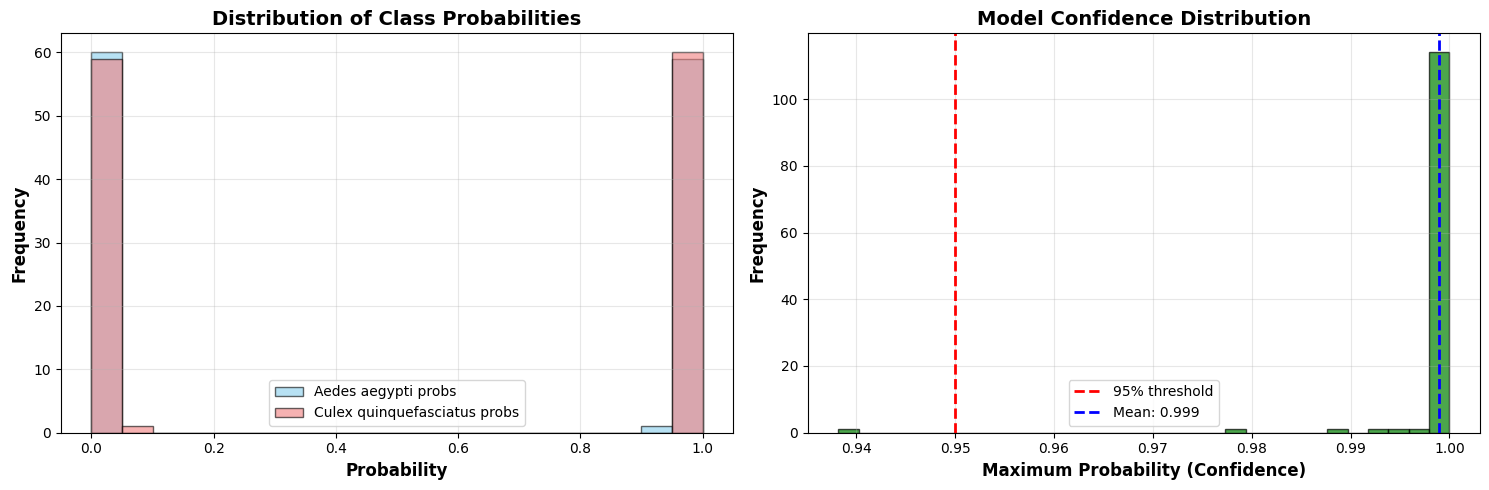


✓ Confidence distribution plot saved as 'confidence_distribution_resnet18.png'

LEAST CONFIDENT PREDICTIONS (All Still Correct - 100% Accuracy)

10 Least confident predictions:

1. ✓ True: Aedes aegypti             | Pred: Aedes aegypti            
   Probs: [0.9382, 0.0618] | Confidence: 93.82%

2. ✓ True: Aedes aegypti             | Pred: Aedes aegypti            
   Probs: [0.9794, 0.0206] | Confidence: 97.94%

3. ✓ True: Aedes aegypti             | Pred: Aedes aegypti            
   Probs: [0.9882, 0.0118] | Confidence: 98.82%

4. ✓ True: Aedes aegypti             | Pred: Aedes aegypti            
   Probs: [0.9921, 0.0079] | Confidence: 99.21%

5. ✓ True: Aedes aegypti             | Pred: Aedes aegypti            
   Probs: [0.9943, 0.0057] | Confidence: 99.43%

6. ✓ True: Aedes aegypti             | Pred: Aedes aegypti            
   Probs: [0.9978, 0.0022] | Confidence: 99.78%

7. ✓ True: Aedes aegypti             | Pred: Aedes aegypti            
   Probs: [0.9984, 0.0016] | C

In [33]:
# ============================================================================
# COMPREHENSIVE CONFIDENCE ANALYSIS
# ============================================================================

# Calculate maximum probabilities (confidence scores)
max_probs = test_probs.max(axis=1)

print("=" * 70)
print("PREDICTION CONFIDENCE ANALYSIS")
print("=" * 70)
print(f"Average confidence: {max_probs.mean():.4f} ({max_probs.mean()*100:.2f}%)")
print(f"Minimum confidence: {max_probs.min():.4f} ({max_probs.min()*100:.2f}%)")
print(f"Maximum confidence: {max_probs.max():.4f} ({max_probs.max()*100:.2f}%)")
print(f"Std deviation: {max_probs.std():.4f}")
print(f"\nPredictions with <99% confidence: {(max_probs < 0.99).sum()} out of {len(max_probs)}")
print(f"Predictions with <95% confidence: {(max_probs < 0.95).sum()} out of {len(max_probs)}")
print(f"Predictions with <90% confidence: {(max_probs < 0.90).sum()} out of {len(max_probs)}")
print("=" * 70)

# ============================================================================
# DATA LEAKAGE CHECK
# ============================================================================
print("\n" + "=" * 70)
print("DATA LEAKAGE CHECK")
print("=" * 70)

train_paths = set(train_df['image_path'].values)
val_paths = set(val_df['image_path'].values)
test_paths = set(test_df['image_path'].values)

overlap_train_val = len(train_paths & val_paths)
overlap_train_test = len(train_paths & test_paths)
overlap_val_test = len(val_paths & test_paths)

print(f"Train-Val overlap: {overlap_train_val} images")
print(f"Train-Test overlap: {overlap_train_test} images")
print(f"Val-Test overlap: {overlap_val_test} images")

if overlap_train_val == 0 and overlap_train_test == 0 and overlap_val_test == 0:
    print("\n✓ NO DATA LEAKAGE DETECTED - All splits are clean!")
else:
    print("\n⚠️ WARNING: Data leakage detected!")
print("=" * 70)

# ============================================================================
# VISUALIZE CONFIDENCE DISTRIBUTION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Both class probabilities
axes[0].hist(test_probs[:, 0], bins=20, alpha=0.6, label='Aedes aegypti probs', 
             color='skyblue', edgecolor='black')
axes[0].hist(test_probs[:, 1], bins=20, alpha=0.6, label='Culex quinquefasciatus probs', 
             color='lightcoral', edgecolor='black')
axes[0].set_xlabel('Probability', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Class Probabilities', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right plot: Maximum probability (confidence)
axes[1].hist(max_probs, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
axes[1].axvline(x=max_probs.mean(), color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {max_probs.mean():.3f}')
axes[1].set_xlabel('Maximum Probability (Confidence)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Model Confidence Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distribution_resnet18.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confidence distribution plot saved as 'confidence_distribution_resnet18.png'")

# ============================================================================
# LEAST CONFIDENT PREDICTIONS
# ============================================================================
print("\n" + "=" * 70)
print("LEAST CONFIDENT PREDICTIONS (All Still Correct - 100% Accuracy)")
print("=" * 70)

# Get indices sorted by confidence (ascending)
confidence_indices = max_probs.argsort()

print("\n10 Least confident predictions:\n")
for i, idx in enumerate(confidence_indices[:10], 1):
    true_label = test_labels[idx]
    pred_label = test_preds[idx]
    prob_0 = test_probs[idx, 0]
    prob_1 = test_probs[idx, 1]
    confidence = max_probs[idx]
    
    correct = "✓" if true_label == pred_label else "✗"
    print(f"{i}. {correct} True: {CLASS_NAMES[true_label]:25s} | Pred: {CLASS_NAMES[pred_label]:25s}")
    print(f"   Probs: [{prob_0:.4f}, {prob_1:.4f}] | Confidence: {confidence*100:.2f}%")
    print()

# ============================================================================
# CONFIDENCE BY CLASS
# ============================================================================
print("=" * 70)
print("CONFIDENCE BY CLASS")
print("=" * 70)

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_mask = test_labels == class_idx
    class_probs = max_probs[class_mask]
    
    print(f"\n{class_name}:")
    print(f"  Number of samples: {class_mask.sum()}")
    print(f"  Average confidence: {class_probs.mean():.4f} ({class_probs.mean()*100:.2f}%)")
    print(f"  Min confidence: {class_probs.min():.4f} ({class_probs.min()*100:.2f}%)")
    print(f"  Max confidence: {class_probs.max():.4f} ({class_probs.max()*100:.2f}%)")
    print(f"  Std deviation: {class_probs.std():.4f}")

print("=" * 70)

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("ANALYSIS SUMMARY")
print("=" * 70)

if max_probs.min() > 0.99:
    print("🔍 All predictions have >99% confidence")
    print("   → This suggests the classification task is relatively easy")
    print("   → The two species are highly distinguishable")
elif max_probs.min() > 0.95:
    print("🔍 All predictions have >95% confidence")
    print("   → High confidence across all predictions")
    print("   → Some variability in difficulty")
else:
    print("🔍 Some predictions have <95% confidence")
    print("   → More challenging classification cases exist")
    print("   → Model shows appropriate uncertainty")

print("\n📊 Dataset difficulty assessment:")
if max_probs.std() < 0.01:
    print("   → Very low variance in confidence = Easy dataset")
elif max_probs.std() < 0.05:
    print("   → Low variance in confidence = Moderately easy dataset")
else:
    print("   → Higher variance in confidence = More realistic difficulty")

print("=" * 70)